In [1]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch.cuda import FloatTensor

# Req for package
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, get_parameter_loss
from SkinLearning.Utils.Dataset import get_dataset, get_split
from SkinLearning.Utils.Plotting import plot_parameter_bars


torch.backends.cudnn.benchmark = True

In [6]:
# Remove one FC LAyer
class RNN_hidden(nn.Module):
    def __init__(self):
        super(RNN_hidden, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Linear(64, 6),   
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        x, h = self.rnn(x, h0)
        
        x = h[-1].reshape(batch_size, -1)
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [605]:
# Remove one FC LAyer
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.GRU(15, 512, batch_first=True, return_sequences=True, return_state=True))
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256 , 128),
            nn.ReLU(),
            nn.Linear(128, 6),   
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        h0 = torch.zeros(1, batch_size, 512).to(x.device)
        x, h, c = self.rnn(x, h0)
        
        x = h[-1].reshape(batch_size, -1)
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [602]:
# Remove one FC LAyer
class RNN_output(nn.Module):
    def __init__(self):
        super(RNN_output, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Linear(64, 6),   
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = out[:, -1, :]
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [8]:
# Remove one FC LAyer
class RNN_orig(nn.Module):
    def __init__(self):
        super(RNN_orig, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(131072, 1024),
            nn.ReLU(),
            nn.Linear(1024 , 512),
            nn.ReLU(),
            nn.Linear(512, 6),   
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = out
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [9]:
# Remove one FC LAyer
class RNN_both(nn.Module):
    def __init__(self):
        super(RNN_both, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256 , 128),
            nn.ReLU(),
            nn.Linear(128, 6),   
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = torch.concat([h[-1], out[:, -1, :]])
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [10]:
# Uses full hidden state
class RNN_fh(nn.Module):
    def __init__(self):
        super(RNN_fh, self).__init__()
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, 256, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128 , 64),
            nn.ReLU(),
            nn.Linear(64, 6),   
        )

    def forward(self, x):
        a = x.shape
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        
        h0 = torch.zeros(1, batch_size, 256).to(x.device)
        out, h = self.rnn(x, h0)
  
        x = h
        x = x.reshape(batch_size, -1)

        
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [11]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 240.77it/s]


In [12]:
train_loader, test_loader = getSplit(dataset)

In [606]:
gru = GRU()

In [607]:
train(train_loader, gru, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:03<00:00, 15.43batch/s, lastLoss=0.0588, valLoss=0.0656]


Epoch 272/550: 100%|███████████████████████████████| 56/56 [00:03<00:00, 17.82batch/s, lastLoss=0.0442, valLoss=0.0476]


Epoch 408/550: 100%|███████████████████████████████| 56/56 [00:02<00:00, 27.89batch/s, lastLoss=0.0355, valLoss=0.0444]


Epoch 544/550: 100%|████████████████████████████████| 56/56 [00:01<00:00, 28.37batch/s, lastLoss=0.0339, valLoss=0.047]


Epoch 550/550: 100%|████████████████████████████████| 56/56 [00:02<00:00, 27.84batch/s, lastLoss=0.0291, valLoss=0.039]


Average train loss: 0.0508178493396875
Average validation loss: 0.05662720746118011


([0.24897803126701287,
  0.16315666373286927,
  0.1432818906115634,
  0.12814944796264172,
  0.12090066141848053,
  0.11589061176138264,
  0.11225943786225148,
  0.10811526674245085,
  0.10840634695653405,
  0.10365819332322904,
  0.10353498985724789,
  0.10143791298781123,
  0.10112264300031322,
  0.09942608951990094,
  0.095992943937225,
  0.09660388515996081,
  0.09675095110599484,
  0.09378521836229733,
  0.09452214398022209,
  0.09438447428068944,
  0.09444847969072205,
  0.09444114406194005,
  0.09373738590095725,
  0.09253590527389731,
  0.09386239293962717,
  0.09100905260337251,
  0.09086611760514123,
  0.0894764865349446,
  0.0903685140822615,
  0.08921321707644633,
  0.08966799519423928,
  0.0871403446154935,
  0.08746859258306879,
  0.08666380627879075,
  0.08646156918257475,
  0.08646008957709585,
  0.08602798823267221,
  0.08505749462970666,
  0.08618721046618052,
  0.0855705136699336,
  0.08396462005163942,
  0.08366561521376882,
  0.08397327004266637,
  0.08316912422222

In [13]:
out = RNN_output()

In [14]:
out_train_loss, out_val_loss =  train(train_loader, out, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 77.23batch/s, lastLoss=0.0611, valLoss=0.0606]


Epoch 272/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 77.11batch/s, lastLoss=0.0488, valLoss=0.0536]


Epoch 408/550: 100%|█████████████████████████████████| 56/56 [00:00<00:00, 76.62batch/s, lastLoss=0.04, valLoss=0.0505]


Epoch 544/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 77.08batch/s, lastLoss=0.0353, valLoss=0.0426]


Epoch 550/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 76.75batch/s, lastLoss=0.0336, valLoss=0.0435]


Average train loss: 0.05341463031737109
Average validation loss: 0.05807556598452907


In [15]:
def test(test_loader, net, scaler):
    net.to(DEVICE)
    net.eval()
    criterion = nn.L1Loss()

    losses = []
    p_losses = []
    mae = []
    orig = []

    with torch.no_grad():
        with tqdm(test_loader, unit=" batch") as it:
            for idx, data in enumerate(it):
                inp, out = data['input'].to(DEVICE), data['output'].to(DEVICE)

                predicted = net(inp)
                
                # Denormalise
                p = scaler.inverse_transform(predicted.cpu().numpy())
                o = scaler.inverse_transform(out.cpu().numpy())
                    
                # Get column wise and overall MAPE
                # Since each column is normalised should also be able to use MAE*100
                p_loss = np.mean(100*(np.abs(o-p)/o), axis=0)
                loss = np.mean(100*(np.abs(o-p)/o))

                curr_mae = criterion(predicted, out).item()
                mae.append(curr_mae)
        
            
                p_losses.append(p_loss)
                losses.append(loss)
                orig.append(curr_mae)

            
    average_mape = 100 - np.mean(losses)
    average_p_loss = 100 - np.mean(p_losses, axis=0)
    mae_mean = np.mean(mae)
    mape2 = 100 - np.mean(orig)
    
    return average_mape, average_p_loss, mae_mean, mape2

In [4]:
test(test_loader, out, scaler)

NameError: name 'test_loader' is not defined

In [16]:
hidden = RNN_hidden()

In [17]:
hidden_train_loss, hidden_val_loss =  train(train_loader, hidden, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 76.48batch/s, lastLoss=0.0585, valLoss=0.0606]


Epoch 272/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 80.46batch/s, lastLoss=0.0468, valLoss=0.0513]


Epoch 408/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 80.72batch/s, lastLoss=0.0419, valLoss=0.0489]


Epoch 544/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 79.74batch/s, lastLoss=0.0354, valLoss=0.0413]


Epoch 550/550: 100%|████████████████████████████████| 56/56 [00:00<00:00, 80.16batch/s, lastLoss=0.0356, valLoss=0.045]


Average train loss: 0.051955766716258386
Average validation loss: 0.056350734458220274


In [18]:
orig = RNN_orig()

In [19]:
orig_train_loss, orig_val_loss =  train(train_loader, orig, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.69batch/s, lastLoss=0.0394, valLoss=0.0467]


Epoch 272/550: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.47batch/s, lastLoss=0.0285, valLoss=0.0428]


Epoch 408/550: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.82batch/s, lastLoss=0.0211, valLoss=0.0424]


Epoch 544/550: 100%|████████████████████████████████| 56/56 [00:02<00:00, 20.83batch/s, lastLoss=0.0161, valLoss=0.046]


Epoch 550/550: 100%|███████████████████████████████| 56/56 [00:02<00:00, 20.84batch/s, lastLoss=0.0165, valLoss=0.0396]


Average train loss: 0.03346331649078903
Average validation loss: 0.0491188680665624


In [20]:
fh = RNN_fh()

In [21]:
fh_train_loss, fh_val_loss =  train(train_loader, fh, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 136/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 78.65batch/s, lastLoss=0.0586, valLoss=0.0599]


Epoch 272/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 80.44batch/s, lastLoss=0.0454, valLoss=0.0481]


Epoch 408/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 79.59batch/s, lastLoss=0.0399, valLoss=0.0448]


Epoch 544/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 80.26batch/s, lastLoss=0.0324, valLoss=0.0386]


Epoch 550/550: 100%|███████████████████████████████| 56/56 [00:00<00:00, 80.24batch/s, lastLoss=0.0337, valLoss=0.0435]


Average train loss: 0.052528273063687625
Average validation loss: 0.056375029975661274


In [22]:
both = RNN_both()

In [167]:
both_train_loss, both_val_loss =  train(train_loader, both, val_loader=test_loader, LR=0.0001, epochs=550)

Using: cuda:0


Epoch 6/550:  71%|█████████████████████████          | 40/56 [00:00<00:00, 70.92batch/s, lastLoss=0.184, valLoss=0.186]


KeyboardInterrupt: 

In [183]:
def getParameterLoss(models, names, test_loader, scaler, return_df=True):
    params = []
    overall = []
    orig_over = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, v, a = test(test_loader, model, scaler)
        overall.append(avg)
        orig_over.append(a)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall,
    })
    
    df = df.set_index("Architecture")

    
    dfs = df.style.set_caption(
        'Average percent correctness 100-MAPE').set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center')
        ]
    }])

    display(dfs)
    
    if return_df:
        return df

In [594]:
df = getParameterLoss([out, hidden, orig, fh, both],["Output[-1]", "Hidden[-1]", "Original (output)", "Hidden", "Hidden[-1] + Output[-1]"], test_loader, scaler)

100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 72.47 batch/s]


,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Output[-1],95.386749,87.415764,99.765572,99.831612,83.912025,94.475594,93.464551
Hidden[-1],95.338058,86.652649,99.781403,99.838104,82.811264,95.071129,93.248768
Original (output),96.105759,86.135475,99.813660,99.796783,85.503998,94.707031,93.677117
Hidden,96.052193,88.966957,99.794205,99.857277,83.501053,94.589096,93.793465
Hidden[-1] + Output[-1],90.820358,27.625023,99.698578,99.070717,-125.862076,-35.478500,25.979012


In [299]:
df.values[0]

array([95.48331451, 87.79656982, 99.7699585 , 99.84432983, 83.53419495,
       94.41182709, 93.47336483])

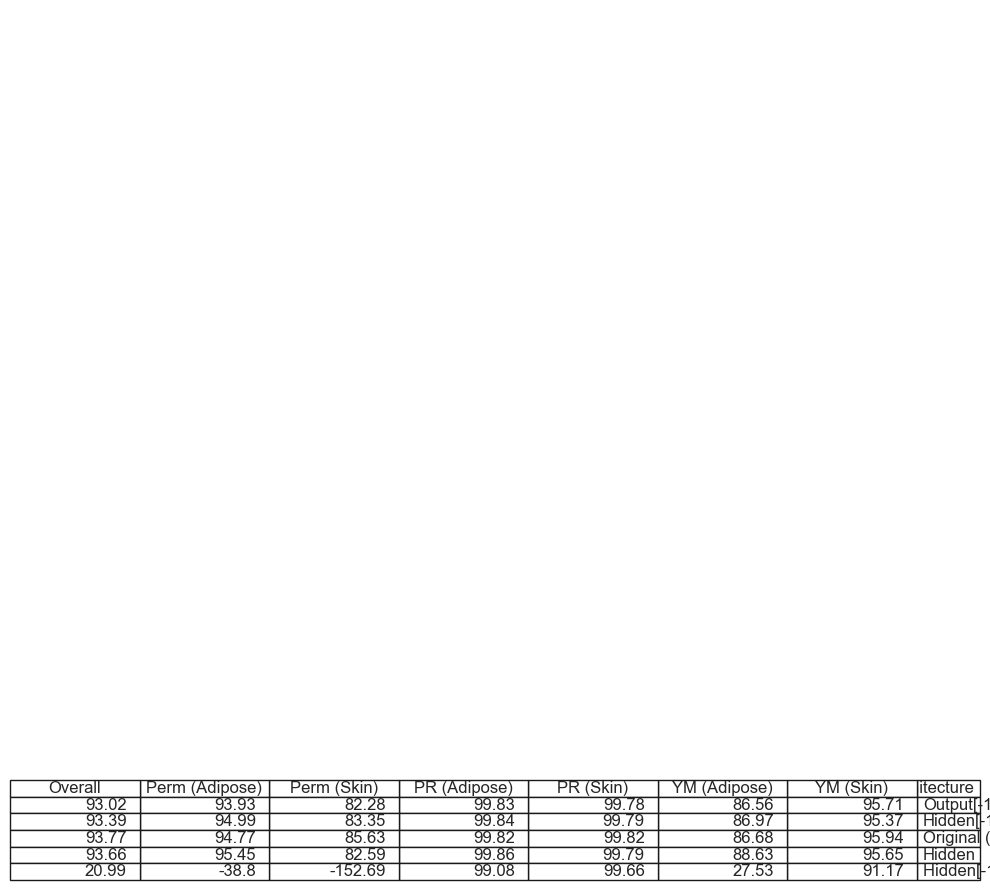

In [270]:
fig, ax = plt.subplots(1, 1,figsize=(13,10), frameon=False, constrained_layout=True)
df = df.astype(float)
df = df.round(2)

table = pd.plotting.table(ax, df)
w, h = table[0,1].get_width(), table[0,1].get_height()
table.add_cell(0, -1, w,h, text=df.index.name)
box = ax.get_position()
ax.set_position([-box.x0, box.y0, -box.width * 0.9, box.height])

ax.margins(x=0, y=0)
ax.axis('off')
ax.grid('off')

In [315]:
np.hstack((df.index.values.reshape(-1, 1), df.values))

array([['Output[-1]', 95.48331451416016, 87.79656982421875,
        99.76995849609375, 99.84432983398438, 83.53419494628906,
        94.41182708740234, 93.47336483001709],
       ['Hidden[-1]', 95.44928741455078, 86.45703125, 99.77960205078125,
        99.82838439941406, 81.4609603881836, 94.8033447265625,
        92.96310186386108],
       ['Original (output)', 95.98358154296875, 86.42693328857422,
        99.81656646728516, 99.81700134277344, 84.07926177978516,
        94.81459045410156, 93.4896559715271],
       ['Hidden', 96.04911804199219, 88.87537384033203,
        99.80089569091797, 99.85614776611328, 83.2332992553711,
        95.6662826538086, 93.91351890563965],
       ['Hidden[-1] + Output[-1]', 90.97343444824219, 14.260185241699219,
        99.71036529541016, 98.98890686035156, -129.5231170654297,
        -36.87223815917969, 22.922935485839844]], dtype=object)

In [307]:
df.index.values.reshape(1, -1)

array([['Output[-1]', 'Hidden[-1]', 'Original (output)', 'Hidden',
        'Hidden[-1] + Output[-1]']], dtype=object)

In [336]:
np.hstack(([df.index.values], df.values))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 5

In [591]:
from matplotlib.font_manager import FontProperties
import six
def save_df(df, fname):
    fig = plt.figure(figsize=(5,5), frameon=False, constrained_layout=True)
    df = df.astype(float)
    df = df.round(2)

    labels = np.concatenate(([df.index.name], df.columns))
    text = np.hstack((df.index.values.reshape(-1, 1), df.values))
    
    table = plt.table(cellText = text, 
                      colLabels = labels,
                      loc='center',
                     )

    plt.axis('off')
    plt.grid('off')
    
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        
        cell.set_edgecolor("none")

            
        if row %2 != 0:
            cell.set_facecolor('gainsboro')

        

    table.auto_set_font_size(False)
    table.set_fontsize(25)
    table.scale(2.5, 2.5)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )
    
    plt.show()

C:\Users\rjsou\AppData\Local\Temp\ipykernel_6100\3280041921.py:35: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )


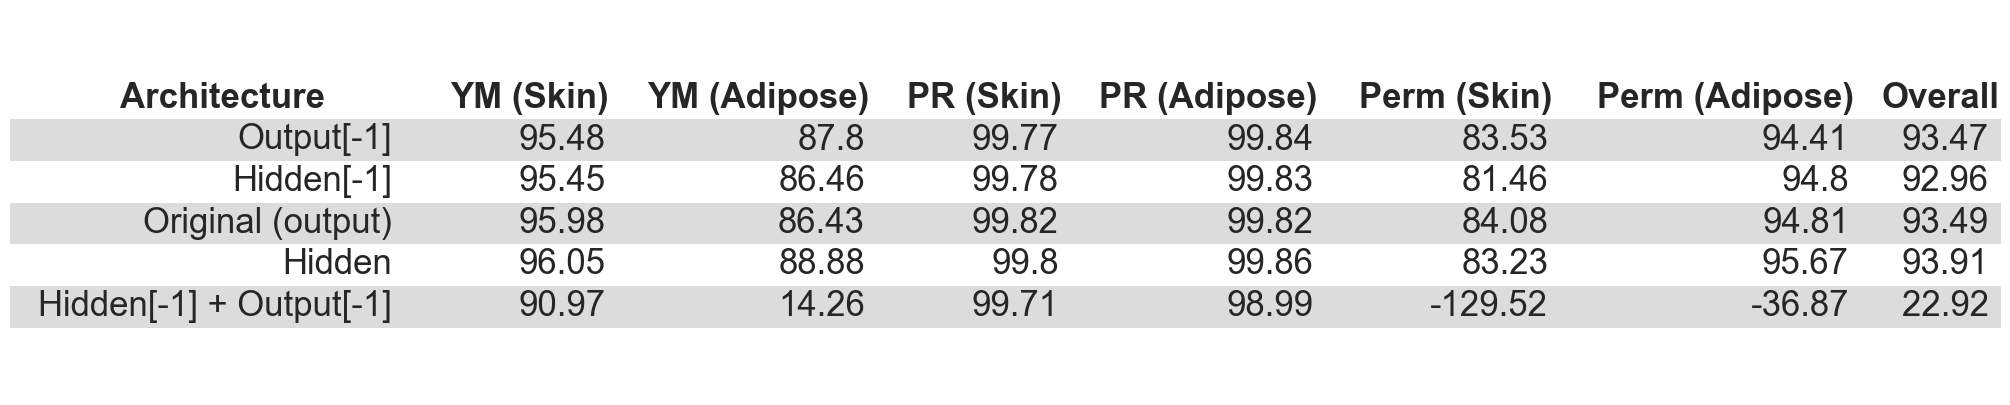

In [592]:
save_df(df, "RNNOutsDF")

In [409]:
models = [out, hidden, orig, fh, both]
names = ["Output[-1]", "Hidden[-1]", "Original (output)", "Hidden", "Hidden[-1] + Output[-1]"]
train_loss = [out_train_loss, hidden_train_loss, orig_train_loss, fh_train_loss, both_train_loss]
val_loss = [out_val_loss, hidden_val_loss, orig_val_loss, fh_val_loss, both_val_loss]

data = [models, train, test]

In [39]:
import pickle

with open("../Results/RNNOut.pkl", "wb") as f:
    pickle.dump(data, f)

In [160]:
sns.set_theme()

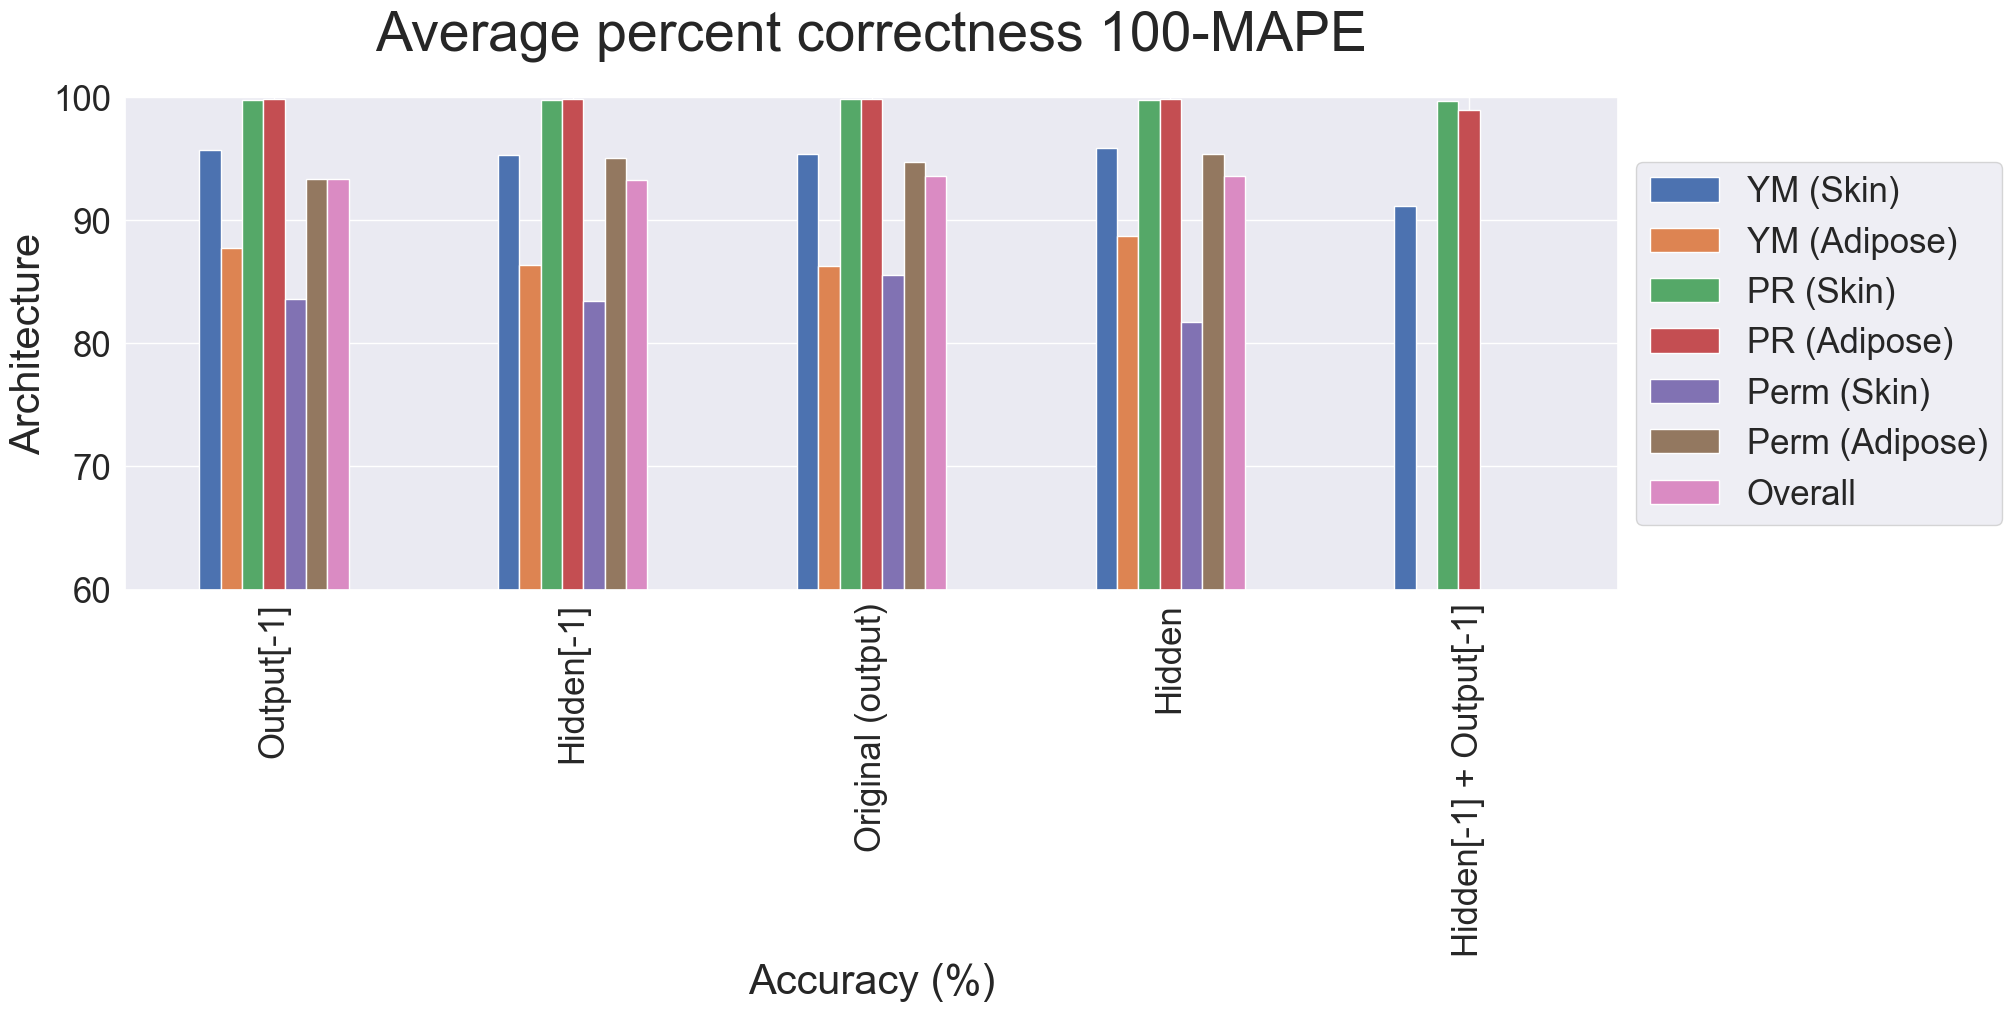

In [172]:
plotParameterBars(df, file_name="RNNOutsBar.svg")

In [163]:
import matplotlib.pyplot as plt
import math
import os

def printCurves(model_names, train_losses, val_losses, epochs=550, fname=None):
    assert len(model_names) == len(train_losses) == len(val_losses)
    
    num_plots = len(model_names)
    num_cols = 2 if num_plots >= 2 else 1
    num_rows = math.ceil(num_plots / num_cols)
    figsize = (20 * num_cols, 15 * num_rows)
    lines = []
    labels = []
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True)
    
    if num_rows == 1 and num_cols == 1:
        axes = [axes]

    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            model_name = model_names[idx]
            train_loss = train_losses[idx]
            val_loss = val_losses[idx]
            epoch_range = range(0, epochs)

            line1, = ax.plot(epoch_range, train_loss, label='Train')
            line2, = ax.plot(epoch_range, val_loss, label='Validation')

            ax.set_title(model_name, fontsize=40)
            ax.tick_params(axis='both', labelsize=35)
            
                        
            if idx == 0:
                lines.extend([line1, line2])
                labels.extend(['Train', 'Validation'])
                
        else:
            ax.axis('off')

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle('Epoch', fontsize=50, x=0.5, y=0.02, horizontalalignment='center', verticalalignment='bottom')
    fig.supylabel('MAE', fontsize=50, x=0.02, y=0.5, horizontalalignment='left', verticalalignment='center', rotation='vertical')
    fig.legend(lines, labels, prop={'size': 50})
    
    if not os.path.exists("../Results/"):
        os.makedirs("../Results/")
    
    if fname:
        plt.savefig(f"../Results/{fname}.svg", format='svg', bbox_inches='tight')
        
    plt.show()
    



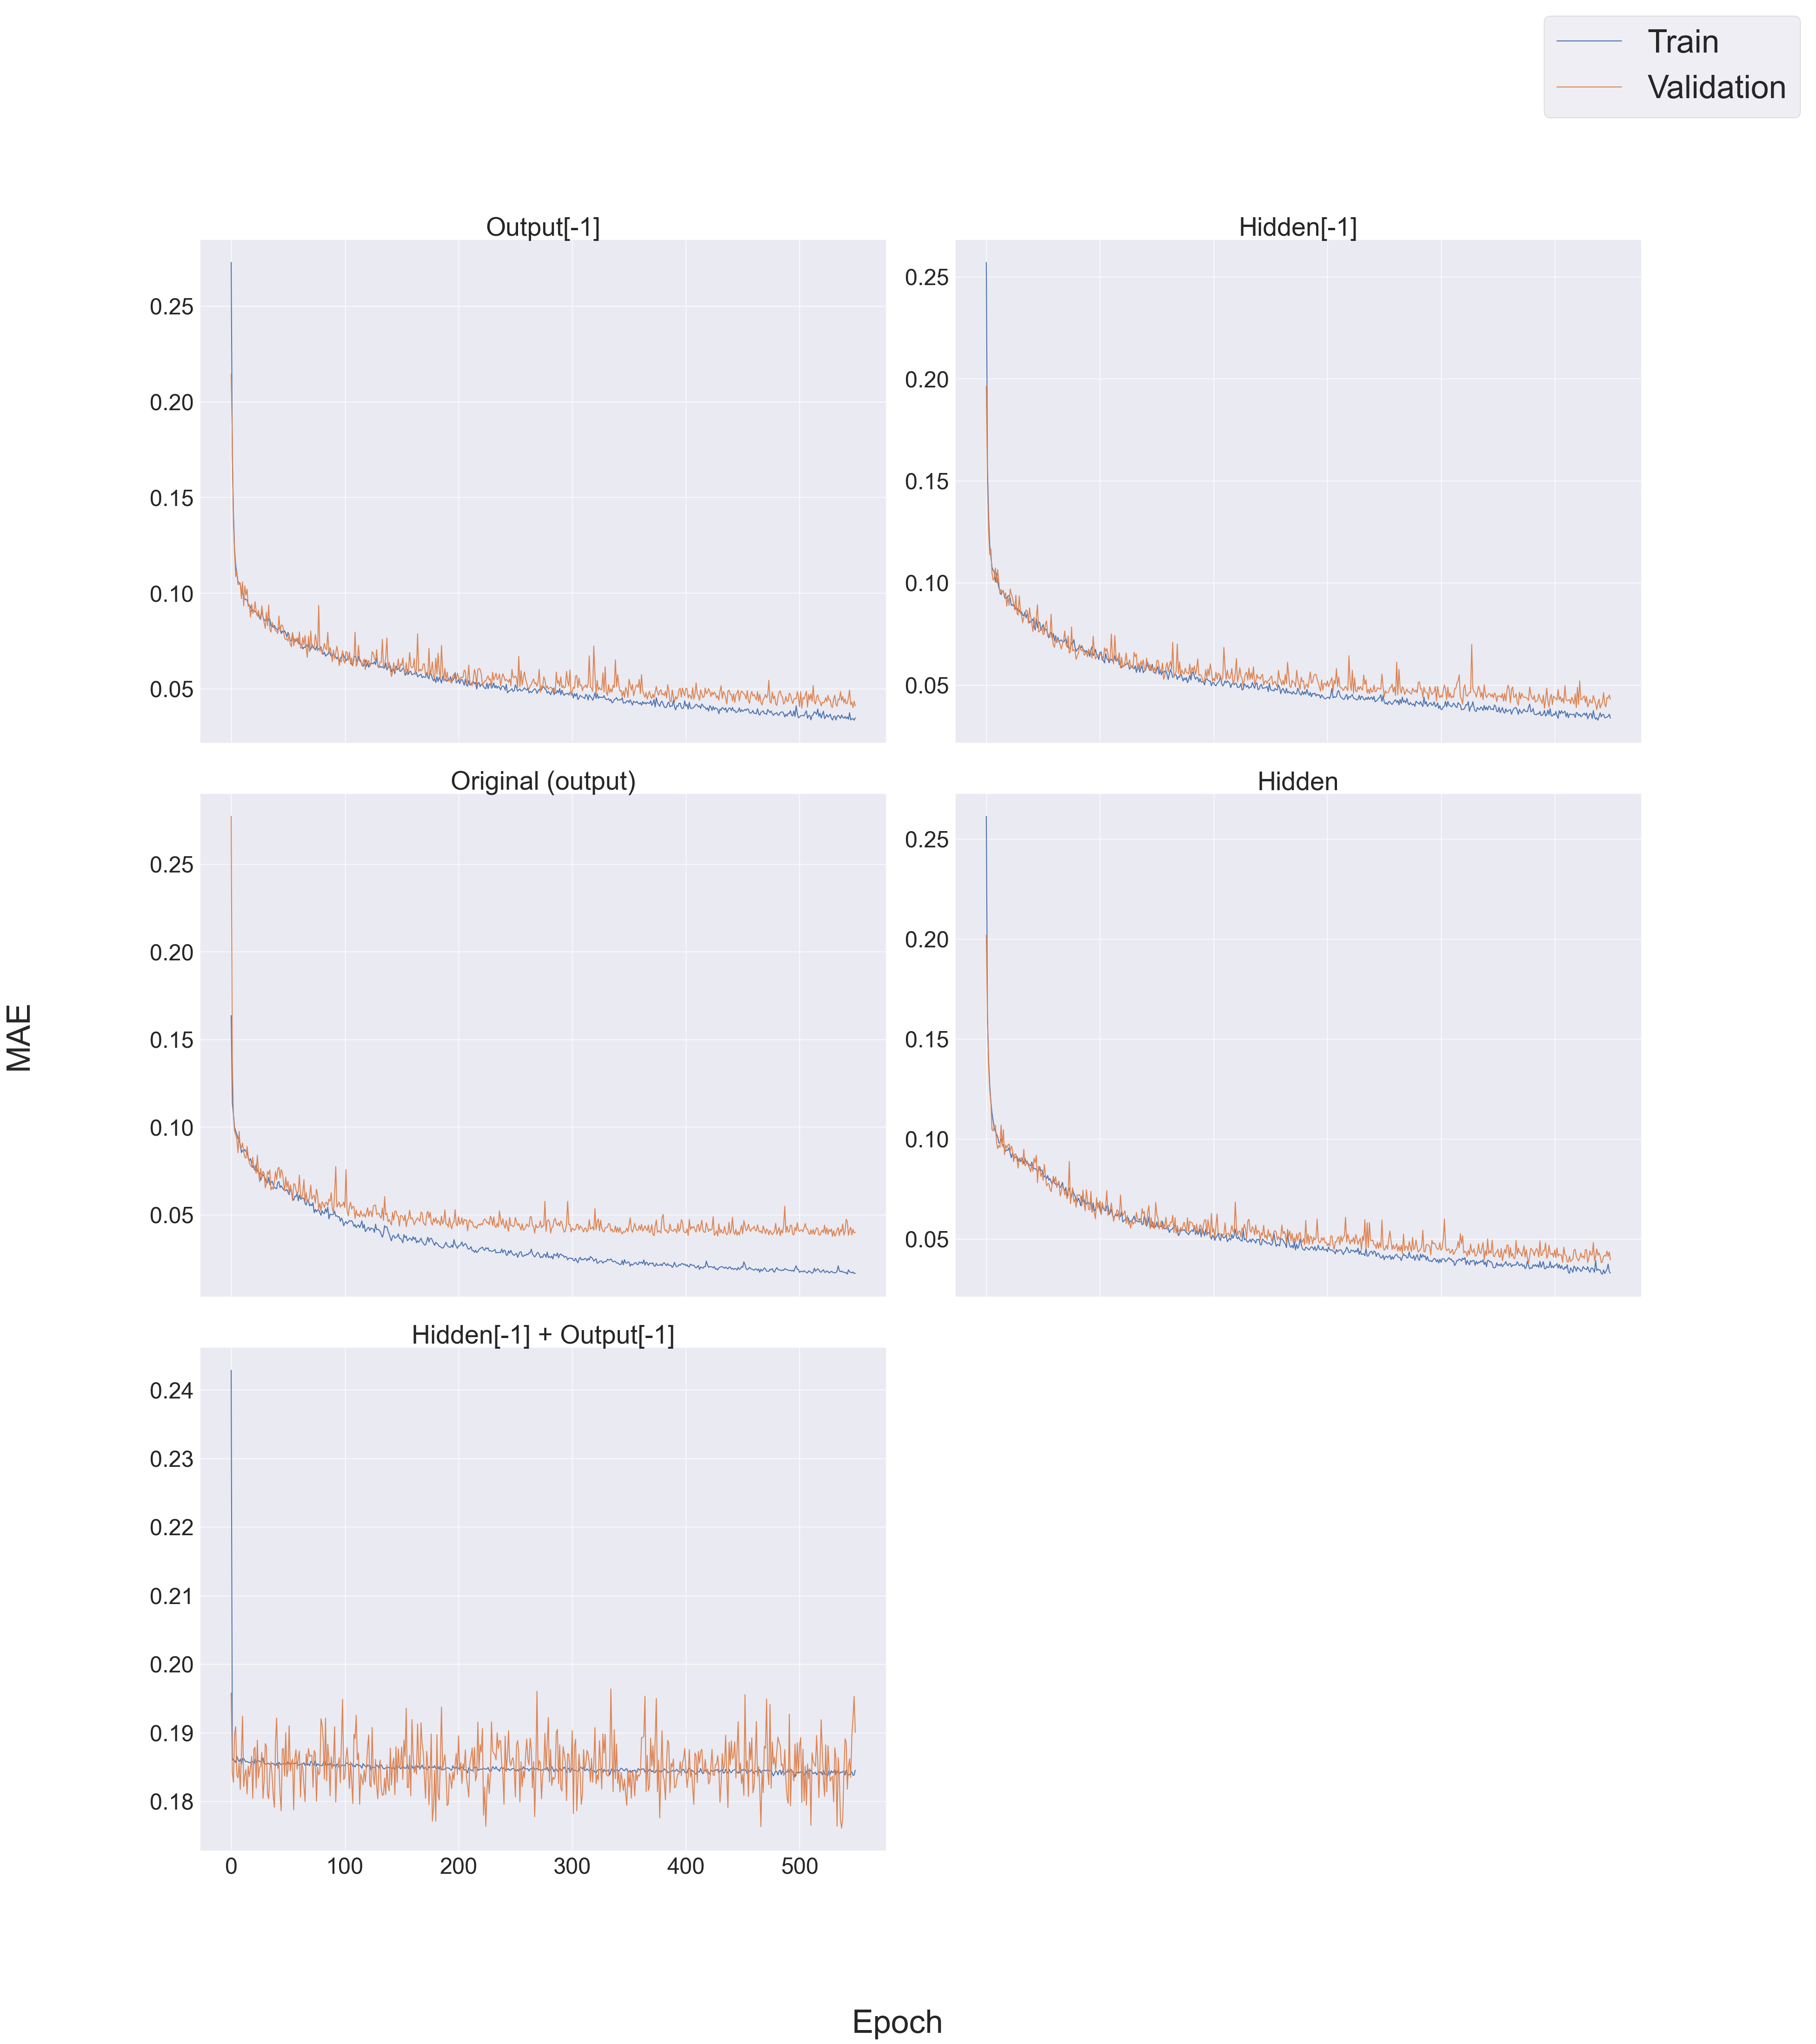

In [165]:
printCurves(names, train_loss, val_loss, fname="RNNoutcurves")

In [72]:
dataset, scaler = get_dataset(runs=[1,2,3,4,5,6,76,34,23,5,6,4,23,14,35,34,34])

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 182.81it/s]


In [73]:
from copy import deepcopy
import torch
from torch import nn

""" Models for testing outputs and RNN derivatives """

""" Best CNN found for feature extraction """
best_CNN = nn.Sequential(
    nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=5, stride=2),

    nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),

    nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
)

In [74]:
class MultiTemporal(nn.Module):
    def __init__(
        self,
        conv=True,
        input_size=15,
        hidden_size=256,
        single_fc=True,
        out="f_hidden",
        layers=1,
        temporal_type="RNN",
        fusion_method="concatenate"
    ):
        super(MultiTemporal, self).__init__()

        self.hidden_size = hidden_size
        self.out = out
        self.temporal_type = temporal_type
        self.fusion_method = fusion_method
        self.input_size = input_size
        self.conv = conv
        
        if conv:
            self.cnn = deepcopy(best_CNN)
        

        if temporal_type == "RNN":
            net = nn.RNN
        elif temporal_type == "LSTM":
            net = nn.LSTM
        elif temporal_type == "GRU":
            net = nn.GRU
        else:
            raise Exception("Not a valid NN type.")

        if fusion_method == 'concatenate':
            self.net = net(input_size, hidden_size, layers, batch_first=True)
        elif fusion_method == 'multi_channel':
            self.net = net(2, hidden_size, layers, batch_first=True)
        elif fusion_method == 'independent':
            self.net = net(input_size//2, hidden_size, layers, batch_first=True)
        else:
            raise ValueError("Invalid method. Choose from 'concatenate', 'multi_channel', or 'independent'.")
        
        fc_in = hidden_size

        if out == "h+o":
            fc_in *= 2
        elif out == "output":
            fc_in *= (2 * hidden_size)


        if fusion_method == "independent":
            fc_in *= 2

        if single_fc:
            self.fc = nn.Linear(fc_in*layers, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(256 if fc_in > 256 and conv == False else fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )
            
            if fc_in > 256 and conv == False:
                if fc_in > 1024:
                     init_layers = nn.Sequential(
                    nn.Linear(fc_in, 1024),
                    nn.ReLU(),
                    nn.Linear(1024, 512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.ReLU()
                    )
                elif fc_in > 512:
                    init_layers = nn.Sequential(
                    nn.Linear(fc_in, 512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.ReLU()
                    )
                else:    
                    init_layers = nn.Sequential(
                    nn.Linear(fc_in, 256),
                    nn.ReLU()
                    )

                    self.fc = nn.Sequential(init_layers, self.fc)
            print("\n")   

    def forward(self, x):
        self.net.flatten_parameters()
        batch_size = x.shape[0]
        
        if self.conv:
            x = self.cnn(x)
        else:
            x = x.reshape(batch_size, -1, self.input_size)

        def get_outputs(inp):
            if self.temporal_type == "LSTM":
                o, (h, _) = self.net(inp)
            else:
                o, h = self.net(inp)
            return o, h

        if self.fusion_method == 'multi_channel':
            o, h = get_outputs(x.view(batch_size, -1, 2))
        elif self.fusion_method == 'independent':
            signal_size = self.input_size // 2
            x1 = x[..., :signal_size].reshape(batch_size, -1, signal_size)
            x2 = x[..., signal_size:].reshape(batch_size, -1, signal_size)
            o1, h1 = get_outputs(x1)
            o2, h2 = get_outputs(x2)
        else:
            o, h = get_outputs(x)

        if self.out == "f_hidden":
            if self.fusion_method == "independent":
                x = torch.cat([h1[-1], h2[-1]], dim=1).reshape(batch_size, -1)
            else:
                x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            if self.fusion_method == "independent":
                x = torch.cat([h1, h2], dim=1).reshape(batch_size, -1)
            else:
                x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            if self.fusion_method == "independent":
                x = torch.cat([o1[:, -1, :], o2[:, -1, :]], dim=1).reshape(batch_size, -1)
            else:
                x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            if self.fusion_method == "independent":
                x = torch.cat([o1, o2], dim=1).reshape(batch_size, -1)
            else:
                print(o.shape)
                x = o.reshape(batch_size, -1)
        elif self.out == "h+o":
            if self.fusion_method == "independent":
                x1 = torch.cat([h1[-1], o1[:, -1, :]], dim=1)
                x2 = torch.cat([h2[-1], o2[:, -1, :]], dim=1)
                x = torch.cat([x1, x2], dim=1).view(batch_size, -1)
            else:
                x = torch.cat([h[-1], o[:, -1, :]], dim=1).view(batch_size, -1)
        print(x.shape)
        x = self.fc(x)
        return x

In [78]:
model = MultiTemporal(out="output")

In [79]:
train_loader, test_loader = get_split(dataset)

In [80]:
train(train_loader, model, epochs=1)

Using: cuda


100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.33batch/s]

torch.Size([27, 512, 256])
torch.Size([27, 131072])
Average train loss: 0.5202200412750244
Average validation loss: 0.0


([0.5202200412750244], [])